# Improved Process Transformer Training

This notebook trains the Process Transformer with **Label Smoothing**, **Class Weights**, and increased **Dropout**.
It is configured to run in Colab and handle Keras versions automatically.


In [1]:
# Install dependencies
!pip install tf_keras
!pip install pm4py pandas numpy scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 35.4 MB/s eta 0:00:00


In [2]:
# HF Access
!pip install huggingface_hub transformers -q

try:
    from google.colab import userdata
    from huggingface_hub import login

    # Access the secret you created
    token = userdata.get('HF_TOKEN')

    # Login with the write permissions
    if token:
        login(token)
        print("✅ Logged in to Hugging Face successfully.")
    else:
        print("⚠️ HF_TOKEN secret not found. Skipping Hugging Face login.")
except ImportError:
    print("⚠️ Not running in Colab or missing dependencies. Skipping HF login.")
except Exception as e:
    print(f"⚠️ HF Login failed: {e}")

⚠️ HF Login failed: Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.


In [3]:
import os
from google.colab import drive

# Mount Drive (Matches your workflow)
drive.mount('/content/drive')

# Working Directory
WORK_DIR = '/content/drive/MyDrive/uni/2026_bpso/BPIC17_ProcessTransformer'
DATA_PATH = f'{WORK_DIR}/data/bpic17_pt.csv'
OUTPUT_DIR = f'{WORK_DIR}/models/process_transformer'

# Create dirs if they don't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Working Directory: {WORK_DIR}")
print(f"Data Path: {DATA_PATH}")
print(f"Output Path: {OUTPUT_DIR}")

# Training Hyperparameters
EPOCHS = 50
BATCH_SIZE = 64
DROPOUT_RATE = 0.2
LABEL_SMOOTHING = 0.1
BALANCED_WEIGHTS = True

Mounted at /content/drive
Working Directory: /content/drive/MyDrive/uni/2026_bpso/BPIC17_ProcessTransformer
Data Path: /content/drive/MyDrive/uni/2026_bpso/BPIC17_ProcessTransformer/data/bpic17_pt.csv
Output Path: /content/drive/MyDrive/uni/2026_bpso/BPIC17_ProcessTransformer/models/process_transformer


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

# Env var for legacy keras (mostly for other libs that check it)
os.environ["TF_USE_LEGACY_KERAS"] = "1"

# ROBUST IMPORT STRATEGY
try:
    import tf_keras as keras
    from tf_keras import layers
    print("✅ Using tf_keras (Legacy) for compatibility.")
except ImportError:
    from tensorflow import keras
    from tensorflow.keras import layers
    print("⚠️ tf_keras not found, using tensorflow.keras. If you see errors, install tf_keras.")

print("TensorFlow Version:", tf.__version__)

✅ Using tf_keras (Legacy) for compatibility.
TensorFlow Version: 2.19.0


In [5]:
def create_process_transformer(
    max_seq_len: int,
    vocab_size: int,
    embed_dim: int = 64,
    num_heads: int = 4,
    ff_dim: int = 128,
    num_blocks: int = 2,
    dropout_rate: float = 0.2,
):
    inputs = layers.Input(shape=(max_seq_len,), dtype=tf.int32)

    embedding = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embed_dim,
        mask_zero=True,
    )(inputs)

    positions = tf.range(start=0, limit=max_seq_len, delta=1)
    position_embedding = layers.Embedding(
        input_dim=max_seq_len,
        output_dim=embed_dim,
    )(positions)

    x = embedding + position_embedding
    x = layers.Dropout(dropout_rate)(x)

    for _ in range(num_blocks):
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=dropout_rate,
        )(x, x)
        attn_output = layers.Dropout(dropout_rate)(attn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

        ffn = keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(embed_dim),
        ])
        ffn_output = ffn(x)
        ffn_output = layers.Dropout(dropout_rate)(ffn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(ff_dim, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(vocab_size, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [6]:
def create_training_examples(sequences, max_len, activity_to_idx):
    X, y = [], []
    start_idx = activity_to_idx['<START>']
    end_idx = activity_to_idx['<END>']
    pad_idx = activity_to_idx['<PAD>']

    for seq in sequences:
        full_seq = [start_idx] + seq + [end_idx]
        for i in range(1, len(full_seq)):
            prefix = full_seq[:i]
            target = full_seq[i]
            if len(prefix) < max_len:
                prefix = [pad_idx] * (max_len - len(prefix)) + prefix
            else:
                prefix = prefix[-max_len:]
            X.append(prefix)
            y.append(target)
    return np.array(X), np.array(y)

In [7]:
# Load
if not os.path.exists(DATA_PATH):
    print(f"❌ Data not found at {DATA_PATH}. Please check Drive path.")
else:
    df = pd.read_csv(DATA_PATH)
    print(f"Loaded {len(df)} events.")

    # Vocab
    activities = df['Activity'].unique().tolist()
    activities = ['<PAD>', '<START>', '<END>'] + sorted(activities)
    activity_to_idx = {act: idx for idx, act in enumerate(activities)}
    idx_to_activity = {idx: act for act, idx in activity_to_idx.items()}
    vocab_size = len(activities)

    # Save Vocab
    with open(f'{OUTPUT_DIR}/vocab.json', 'w') as f:
        json.dump({
            'activity_to_idx': activity_to_idx,
            'idx_to_activity': {str(k): v for k, v in idx_to_activity.items()},
            'vocab_size': vocab_size,
        }, f, indent=2)

    # Process
    df['activity_idx'] = df['Activity'].map(activity_to_idx)
    cases = df.groupby('Case ID')['activity_idx'].apply(list).reset_index()
    max_case_length = cases['activity_idx'].apply(len).max()
    MAX_SEQ_LEN = min(max_case_length + 2, 100)

    # Save Config
    with open(f'{OUTPUT_DIR}/config.json', 'w') as f:
        json.dump({
            'max_seq_len': MAX_SEQ_LEN,
            'vocab_size': vocab_size,
            'dropout': DROPOUT_RATE,
            'label_smoothing': LABEL_SMOOTHING
        }, f, indent=2)

    # Split
    train_cases, val_cases = train_test_split(cases['activity_idx'].tolist(), test_size=0.2, random_state=42)

    print("Generating examples...")
    X_train, y_train = create_training_examples(train_cases, MAX_SEQ_LEN, activity_to_idx)
    X_val, y_val = create_training_examples(val_cases, MAX_SEQ_LEN, activity_to_idx)

    # One-hot
    y_train_onehot = keras.utils.to_categorical(y_train, num_classes=vocab_size)
    y_val_onehot = keras.utils.to_categorical(y_val, num_classes=vocab_size)

    # Weights
    class_weights_dict = None
    if BALANCED_WEIGHTS:
        unique = np.unique(y_train)
        weights = class_weight.compute_class_weight('balanced', classes=unique, y=y_train)
        cw_map = dict(zip(unique, weights))
        # Fill missing keys
        class_weights_dict = {i: 1.0 for i in range(vocab_size)}
        for k, v in cw_map.items():
            class_weights_dict[int(k)] = v

    # Model
    model = create_process_transformer(MAX_SEQ_LEN, vocab_size, dropout_rate=DROPOUT_RATE)
    loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
    model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=loss_fn, metrics=['accuracy'])

    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
        keras.callbacks.ModelCheckpoint(f'{OUTPUT_DIR}/model.keras', monitor='val_loss', save_best_only=True)
    ]

    history = model.fit(
        X_train, y_train_onehot,
        validation_data=(X_val, y_val_onehot),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        class_weight=class_weights_dict,
        verbose=1
    )

Loaded 471372 events.
Generating examples...
Epoch 1/50
6273/6273 [==============================] - 107s 15ms/step - loss: 1.6957 - accuracy: 0.6010 - val_loss: 1.3030 - val_accuracy: 0.6813 - lr: 1.0000e-04
Epoch 2/50
6273/6273 [==============================] - 91s 15ms/step - loss: 1.3477 - accuracy: 0.6897 - val_loss: 1.2699 - val_accuracy: 0.7030 - lr: 1.0000e-04
Epoch 3/50
6273/6273 [==============================] - 91s 15ms/step - loss: 1.3083 - accuracy: 0.7007 - val_loss: 1.2877 - val_accuracy: 0.7118 - lr: 1.0000e-04
Epoch 4/50
6273/6273 [==============================] - 91s 15ms/step - loss: 1.2862 - accuracy: 0.7034 - val_loss: 1.2479 - val_accuracy: 0.6959 - lr: 1.0000e-04
Epoch 5/50
6273/6273 [==============================] - 107s 17ms/step - loss: 1.2698 - accuracy: 0.7046 - val_loss: 1.2528 - val_accuracy: 0.7123 - lr: 1.0000e-04
Epoch 6/50
6273/6273 [==============================] - 92s 15ms/step - loss: 1.2576 - accuracy: 0.7050 - val_loss: 1.2454 - val_accuracy:

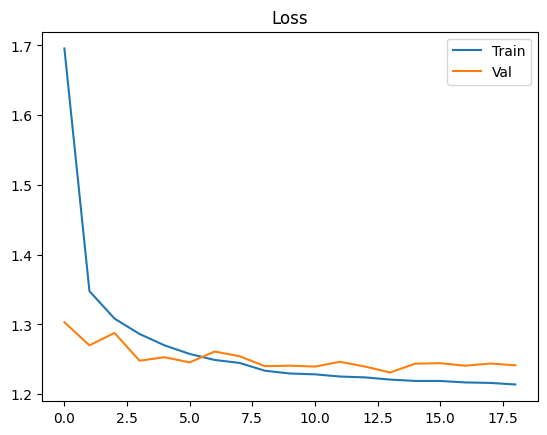

In [8]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

In [9]:
# --- Save & Export ---

# Upload to Hugging Face (Optional)
# Requires that you ran the Login cell earlier
try:
    from huggingface_hub import HfApi, create_repo
    api = HfApi()

    # Get your username
    user = api.whoami()['name']
    repo_id = f"{user}/process-transformerv2"

    print(f"\n🚀 Creating/Checking Repo: {repo_id}...")
    create_repo(repo_id, exist_ok=True)

    print("📤 Uploading files...")
    # Upload the 'best' model from the checkpoint
    api.upload_file(
        path_or_fileobj=f"{OUTPUT_DIR}/model.keras",
        path_in_repo="model.keras",
        repo_id=repo_id
    )
    # Upload config & vocab
    api.upload_file(
        path_or_fileobj=f"{OUTPUT_DIR}/config.json",
        path_in_repo="config.json",
        repo_id=repo_id
    )
    api.upload_file(
        path_or_fileobj=f"{OUTPUT_DIR}/vocab.json",
        path_in_repo="vocab.json",
        repo_id=repo_id
    )

    print(f"✅ Download your model here: https://huggingface.co/{repo_id}")

except Exception as e:
    print(f"\n⚠️ Hugging Face upload skipped/failed: {e}")


🚀 Creating/Checking Repo: lgk03/process-transformerv2...
📤 Uploading files...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...s_transformer/model.keras:  23%|##3       |  556kB / 2.39MB            

✅ Download your model here: https://huggingface.co/lgk03/process-transformerv2
